In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelBinarizer 
from tensorflow import keras 
import datetime 
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.image as mpimg
from PIL import Image
import tensorflow
import cv2

In [2]:
Image_Data = np.load('Part 1- Train data - images.npy',encoding='bytes',allow_pickle=True)

In [3]:
# Setting image dimensions to 224
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

In [4]:
# Creating features and labels
# Feature is IMAGE, label is MASK
# Images will be in Array X
# Masks will be in Array M

from tensorflow.keras.applications.mobilenet import preprocess_input

M = np.zeros((int(Image_Data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))#Creating  the array for Mask details
X = np.zeros((int(Image_Data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))#Creating  the array for Image details
for index in range(Image_Data.shape[0]):
    img = Image_Data[index][0]#Read the image
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)#Resize the image to 224*224
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in Image_Data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)#Getting the x& y coordinates
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        #Appending to Mask Array M
        M[index][y1:y2, x1:x2] = 1

In [5]:
# Splitting data into training and testing.

X_train = X[:308]
y_train=M[:308]
X_test = X[-8:]
y_test=M[-8:]
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('\nX_test:',X_test.shape)
print('y_test:',y_test.shape)

X_train: (308, 224, 224, 3)
y_train: (308, 224, 224)

X_test: (8, 224, 224, 3)
y_test: (8, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


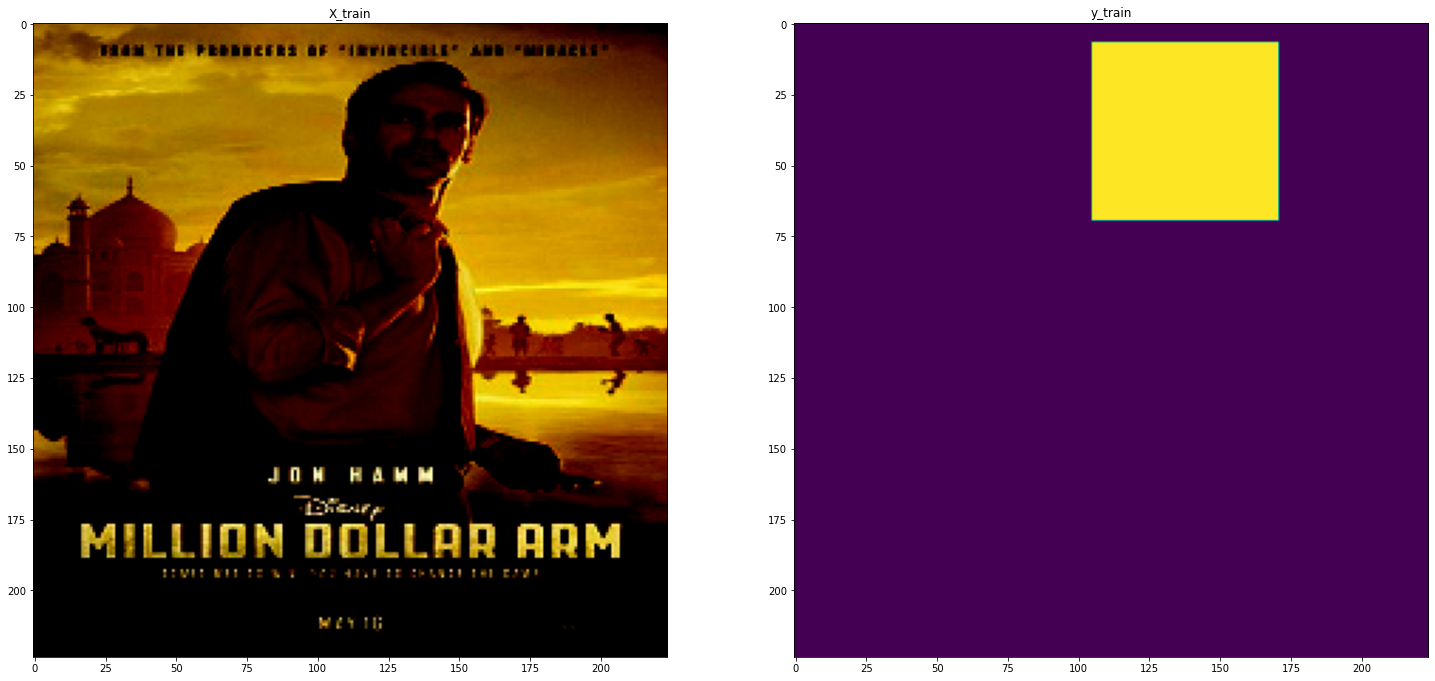

In [7]:
# Displaying an image from the train data.

ax = []
fig = plt.figure(figsize=(25, 25))
ax.append(fig.add_subplot(1, 2, 1))
plt.imshow(X_train[300])
ax[0].set_title('X_train')
ax.append(fig.add_subplot(1, 2, 2))
ax[1].set_title('y_train')
plt.imshow(y_train[300])
plt.show()

In [10]:
# Creating a Mask Detection Model.

from tensorflow.keras.applications.mobilenet import MobileNet#Importing the Mobilenet model
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D#Importing the Layers
from tensorflow.keras.models import Model

def model_create(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")#Calling the mobilenet model

    for layer in model.layers:
        layer.trainable = trainable
        #adding Unet Architecture to the layers.
    block0 = model.get_layer("conv_pw_1_relu").output 
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)

#Creating Model by calling the function.
HEIGHT_CELLS = 28
WIDTH_CELLS = 28
model = model_create(False)

17227776/17225924 [==============================] - 4s 0us/step


In [12]:
# creating dice co-efficient Function

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [13]:
# Creating the loss function.

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [14]:
# Compiling the Model.
# Use Adam OPtimizer. 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 

model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [15]:
# Fitting the Model.

model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
308/308 [==============================] - 143s 465ms/step - loss: 2.2837 - dice_coefficient: 0.2352
Epoch 2/100
308/308 [==============================] - 140s 454ms/step - loss: 1.4089 - dice_coefficient: 0.3828
Epoch 3/100
308/308 [==============================] - 136s 442ms/step - loss: 1.1779 - dice_coefficient: 0.4524
Epoch 4/100
308/308 [==============================] - 133s 430ms/step - loss: 1.0787 - dice_coefficient: 0.4887
Epoch 5/100
308/308 [==============================] - 139s 452ms/step - loss: 1.0155 - dice_coefficient: 0.5127
Epoch 6/100
308/308 [==============================] - 140s 454ms/step - loss: 0.9770 - dice_coefficient: 0.5290
Epoch 7/100
308/308 [==============================] - 141s 459ms/step - loss: 0.9458 - dice_coefficient: 0.5417
Epoch 8/100
308/308 [==============================] - 140s 456ms/step - loss: 0.9238 - dice_coefficient: 0.5517
Epoch 9/100
308/308 [==============================] - 140s 454ms/step - loss: 0.9058 - dice_coe

Epoch 73/100
308/308 [==============================] - 134s 435ms/step - loss: 0.6764 - dice_coefficient: 0.6516
Epoch 74/100
308/308 [==============================] - 134s 435ms/step - loss: 0.6755 - dice_coefficient: 0.6522
Epoch 75/100
308/308 [==============================] - 134s 435ms/step - loss: 0.6754 - dice_coefficient: 0.6522
Epoch 76/100
308/308 [==============================] - 132s 429ms/step - loss: 0.6718 - dice_coefficient: 0.6536
Epoch 77/100
308/308 [==============================] - 132s 428ms/step - loss: 0.6728 - dice_coefficient: 0.6534
Epoch 78/100
308/308 [==============================] - 132s 429ms/step - loss: 0.6708 - dice_coefficient: 0.6537
Epoch 79/100
308/308 [==============================] - 131s 426ms/step - loss: 0.6705 - dice_coefficient: 0.6546
Epoch 80/100
308/308 [==============================] - 132s 427ms/step - loss: 0.6707 - dice_coefficient: 0.6547
Epoch 81/100
308/308 [==============================] - 131s 425ms/step - loss: 0.6697 -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


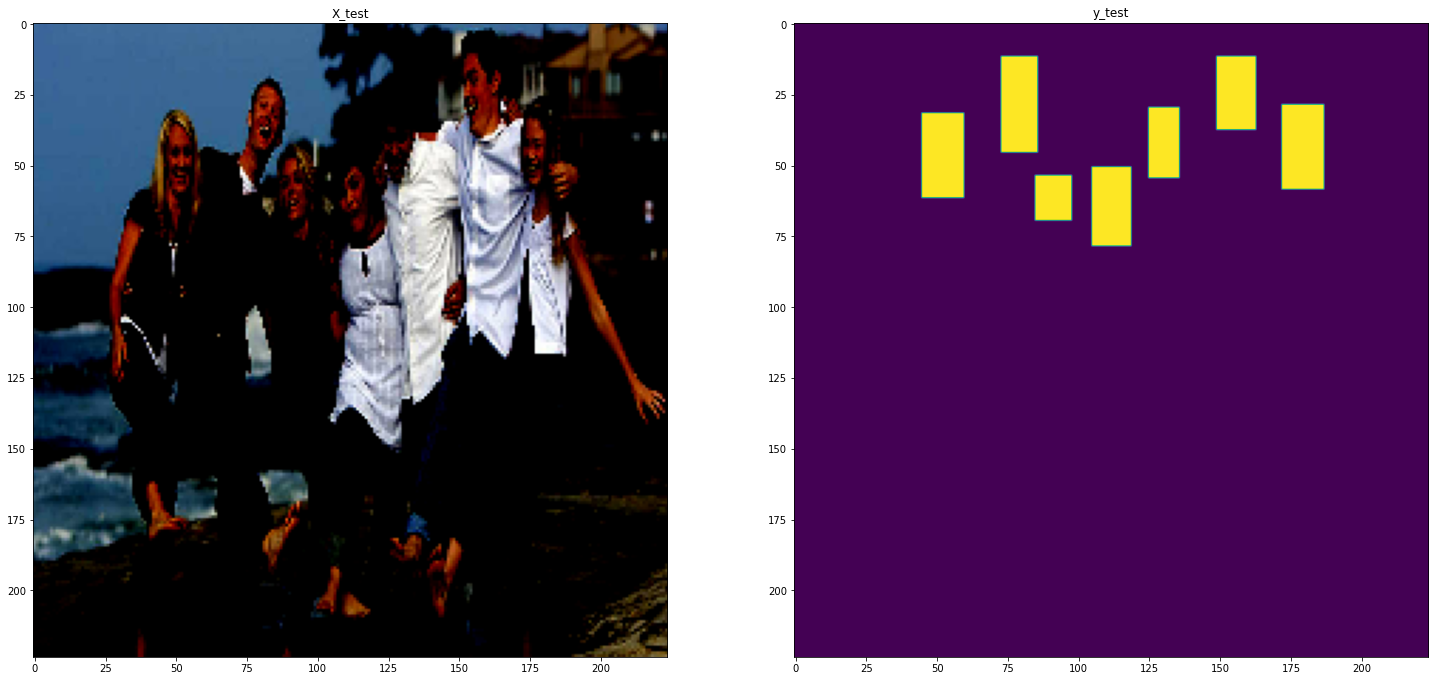

In [24]:
# Displaying test Image and Mask Image 

ax = []
fig = plt.figure(figsize=(25, 25))
ax.append(fig.add_subplot(1, 2, 1))
plt.imshow(X_test[1])
ax[0].set_title('X_test')
ax.append(fig.add_subplot(1, 2, 2))
ax[1].set_title('y_test')
plt.imshow(y_test[1])
plt.show()

In [25]:
# Predicting the model

pred_M = model.predict(X_test,verbose=1)

1/1 [==============================] - 0s 3ms/step


In [34]:
def plot_sample(X, y, preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors=('r', 'green', 'blue', (1, 1, 0), '#afeeee', '0.5'), levels=[0.5])
    ax[0].set_title('Original Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Original Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors=('r', 'green', 'blue', (1, 1, 0), '#afeeee', '0.5'), levels=[0.5])
    ax[2].set_title('Predicted Mask')

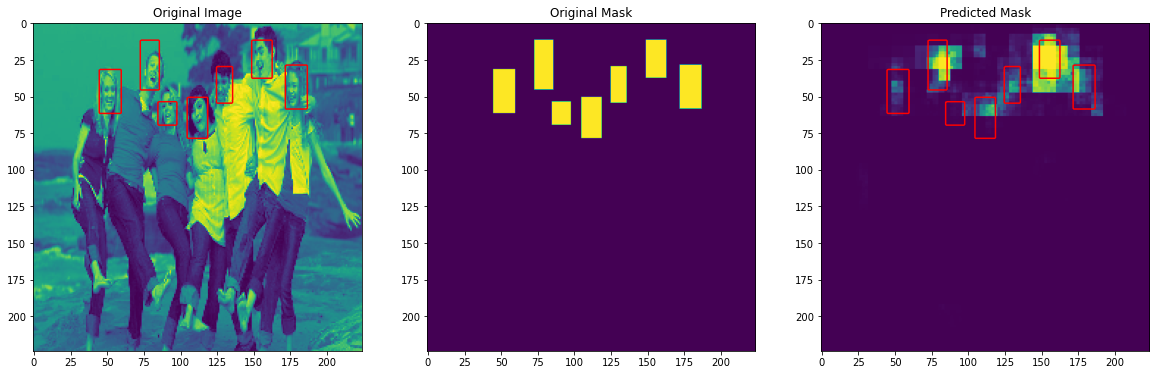

In [35]:
plot_sample(X_test, y_test, pred_M, ix=1)

* Loss being 0.6571
* Dice co-efficient = 0.6606